<a href="https://colab.research.google.com/github/NilakshanKunananthaseelan/MachineLearning/blob/main/DANN/notebooks/GradientReversalLayer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Gradient Reversal Layer(GRL)
From Domain-Adversarial Neural Network(DANN), a method which combines representation learning and unsupervised domain adaptation in an end-to-end training process.

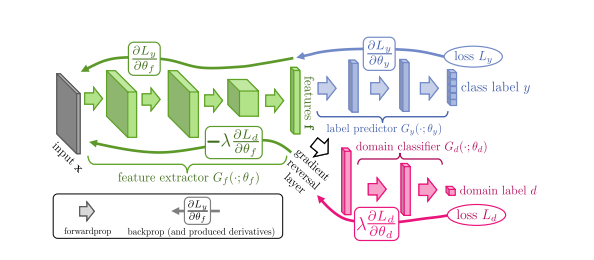


*   GRL leaves the input unchanged during the foward propagation and reverses the gradient by multiplying it by a negative scaler during the back propagation
*   This notebook has an implementation of GRL in PyTorch.
<br>

[[AUTOMATIC DIFFERENTIATION PACKAGE]](https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html)
[[EXTENDING PYTORCH]](https://pytorch.org/docs/stable/notes/extending.html)
[[IPYTEST]](https://github.com/chmp/ipytest)



In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Function
import pytest
from copy import deepcopy

In [ ]:
class GradientReversal(Function):
  """
  This custom autograd class implements gradient reersal function
  """

  @staticmethod
  def forward(ctx, input,lamda):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(input,lamda)
        output  = input
        return output

  @staticmethod
  def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        input,lamda = ctx.saved_tensors
        grad_input = None
        if ctx.needs_input_grad[0]:
          grad_input = grad_output.neg()*lamda


        return grad_input,None



In [ ]:
class GradientReversalLayer(nn.Module):
  def __init__(self,lamda=1.0,*args,**kwargs):
    """
    A gradient reversal layer

    This layer only reverses the gradient(sometimes multiplies with a non-zero constant) in the backward propagation

    grad_input = -grad_outpu*alpha
    """

    super().__init__(*args,**kwargs)

    self.lamda = torch.tensor(lamda,requires_grad=False)
             

  def forward(self,x):
    return GradientReversal.apply(x,self.lamda)

In [ ]:
def get_tensor(shape=(10,3,224,224),index=0):
    x = torch.zeros(shape)
    try:
        s = shape[2]
        x[:,:,0:s//2,:] = (index+10)
        x[:,:,s//2:,:] = -(index+10)
    except:
        s = shape[1]
        x[:,0:s//2] = (index+10)
        x[:,s//2:] = -(index+10)
        
    return x


In [ ]:
def test_gradient_reversal():
  model = nn.Sequential(nn.Linear(16,4),nn.Linear(4,1))
  grl = GradientReversalLayer()
  model_grl  =   nn.Sequential(deepcopy(model),grl)

  input = get_tensor((10,16))
  output = get_tensor((10,1))


  criterion = nn.MSELoss()

  criterion(model(input),output).backward()
  criterion(model_grl(input),output).backward()


  assert all(
        (p1.grad == -p2.grad).all()
        for p1, p2 in zip(model.parameters(), model_grl.parameters())
    )
  



In [ ]:
test_gradient_reversal()


In [ ]:
import ipytest

In [ ]:
%%ipytest -qq

@pytest.mark.parametrize(
    ("lamda"), [(0.5), (0.7), (0.1), (30.),(0.001)],
)
def test_gradients_reveral_with_lamda(lamda):
  model= torch.nn.Sequential(torch.nn.Linear(16,4), torch.nn.Linear(4, 1))
  model_grl = torch.nn.Sequential(
        deepcopy(model), GradientReversalLayer(lamda=lamda)
    )

  input = get_tensor((10,16))
  output = get_tensor((10,1))


  criterion = nn.MSELoss()

  criterion(model(input),output).backward()
  criterion(model_grl(input),output).backward()

  for p1, p2 in zip(model.parameters(), model_grl.parameters()):
        assert torch.isclose(p1.grad, -p2.grad/lamda).all()

In [ ]:
ipytest.run()